<a href="https://colab.research.google.com/github/DongDong-Zoez/ComputerVision/blob/main/UNet%2B%2B/UNet%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train UNet from scratch

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Split the image to training and validation

In [3]:
#import splitfolders
#splitfolders.ratio(input='/content/gdrive/MyDrive/AnimeFace/', output='/content/gdrive/MyDrive/AnimeFace/split', seed=1337, ratio=(0.8, 0.2))

# UNet++ Architecture

TO DO:

1. In encoder part, use Conv2d replace MaxPool2d, and see how it works.
2. In decoder part, use ConvTranpose2d replace Upsample, and see how it works.

NOTE:

1. in_channels = 3 for RGB images
2. change out_channels to your custom setting

In [2]:
from torch import nn
import torch

class DownSampleLayer(nn.Module):
    
    def __init__(self, in_ch):
        super(DownSampleLayer, self).__init__()
        
        self.Downsample = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=in_ch, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=in_ch),
            nn.ReLU()
        )
        
    def forward(self, x):
        
        x = self.Downsample(x)
        
        return x
    
class UpSampleLayer(nn.Module):
    
    def __init__(self, in_ch):
        super(UpSampleLayer, self).__init__()
        
        self.Upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_ch, out_channels=in_ch, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features=in_ch),
            nn.ReLU()
        )
        
    def forward(self, x):
        
        x = self.Upsample(x)
        
        return x
    
class DoubleConv(nn.Module):
    
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        
        self.doubleConv = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_ch),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_ch),
            nn.ReLU()
        )
        

    def forward(self, x):
        
        x = self.doubleConv(x)
        
        return x

    
class UNetPlusPlus(nn.Module):
    
    def __init__(self, deep=4):
        super(UNetPlusPlus, self).__init__()

        def cat(TensorList, x):
            return torch.cat((*TensorList, x), dim=1)
        
        self.deep = deep      
        
        if self.deep not in range(1,5):
            return "The deep of network must be an integer in 1<=L<=4"
        
        in_channels = 1 #RGB
        out_channels= [32,64,128,256,512] #image tile
        
        self.down = nn.ModuleList([DownSampleLayer(out_channels[i]) for i in range(4)])
        self.up = nn.ModuleList([UpSampleLayer(out_channels[i+1]) for i in range(4)])
        
        self.cat = cat
        
        self.c0_0 = DoubleConv(in_channels, out_channels[0])
        self.c0_1 = DoubleConv(out_channels[0]+out_channels[1], out_channels[0])
        self.c0_2 = DoubleConv(out_channels[0]*2+out_channels[1], out_channels[0])
        self.c0_3 = DoubleConv(out_channels[0]*3+out_channels[1], out_channels[0])
        self.c0_4 = DoubleConv(out_channels[0]*4+out_channels[1], out_channels[0])
        
        self.c1_0 = DoubleConv(out_channels[0], out_channels[1])
        self.c1_1 = DoubleConv(out_channels[1]+out_channels[2], out_channels[1])
        self.c1_2 = DoubleConv(out_channels[1]*2+out_channels[2], out_channels[1])
        self.c1_3 = DoubleConv(out_channels[1]*3+out_channels[2], out_channels[1])
        
        self.c2_0 = DoubleConv(out_channels[1], out_channels[2])
        self.c2_1 = DoubleConv(out_channels[2]+out_channels[3], out_channels[2])
        self.c2_2 = DoubleConv(out_channels[2]*2+out_channels[3], out_channels[2])
        
        self.c3_0 = DoubleConv(out_channels[2], out_channels[3])
        self.c3_1 = DoubleConv(out_channels[3]+out_channels[4], out_channels[3])
        
        self.c4_0 = DoubleConv(out_channels[3], out_channels[4])
        
        self.output = nn.Conv2d(out_channels[0], 1, kernel_size=1, stride=1)

        
    def forward(self, x0_0):
        
        output = []
        
        x0_0 = self.c0_0(x0_0)
        x1_0 = self.c1_0(self.down[0](x0_0))
        x0_1 = self.c0_1(self.cat([x0_0], self.up[0](x1_0)))
        output.append(self.output(x0_1))
        
        if self.deep == 1:
            return sum(output) / len(output)
        
        x2_0 = self.c2_0(self.down[1](x1_0))
        x1_1 = self.c1_1(self.cat([x1_0], self.up[1](x2_0)))
        x0_2 = self.c0_2(self.cat([x0_0, x0_1], self.up[0](x1_1)))
        output2 = self.output(x0_2)
        
        if self.deep == 2:
            return sum(output) / len(output)
        
        x3_0 = self.c3_0(self.down[2](x2_0))
        x2_1 = self.c2_1(self.cat([x2_0], self.up[2](x3_0)))
        x1_2 = self.c1_2(self.cat([x1_0, x1_1], self.up[1](x2_1)))
        x0_3 = self.c0_3(self.cat([x0_0, x0_1, x0_2], self.up[0](x1_2)))
        output3 = self.output(x0_3)
        
        if self.deep == 3:
            return sum(output) / len(output)
        
        x4_0 = self.c4_0(self.down[3](x3_0))
        x3_1 = self.c3_1(self.cat([x3_0], self.up[3](x4_0)))
        x2_2 = self.c2_2(self.cat([x2_0, x2_1], self.up[2](x3_1)))
        x1_3 = self.c1_3(self.cat([x1_0, x1_1, x1_2], self.up[1](x2_2)))
        x0_4 = self.c0_4(self.cat([x0_0, x0_1, x0_2, x0_3], self.up[0](x1_3)))
        output4 = self.output(x0_4)
        
        if self.deep == 4:
            return sum(output) / len(output)

    def toDevice(self, device):
        for i in range(len(self.up)):
            self.up[i].to(device)
            self.down[i].to(device)

#Build Dataset

Note : We use the dataset [ISBI](https://github.com/hoangp/isbi-datasets)

In [4]:
import torch
import cv2
import os
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

class ISBIDataset(Dataset):
    def __init__(self, transform=None, path="/content/gdrive/MyDrive/train/image/"):

        self.path = path
        self.transforms = transform
        for root, dirs, files in os.walk(self.path):
            self.imgs = [self.path + file for file in files]
        
    def __getitem__(self, idx):

        image_path = self.imgs[idx]
        label_path = image_path.replace('image', 'label')

        image = cv2.imread(image_path) # read image with BGR channels
        label = cv2.imread(label_path) # read image with BGR channels

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # To gray scale
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY) # To gray scale

        image = image[None,...] # add gray scale channel
        label = label[None,...] # add gray scale channel

        #if self.transforms:
        #    image = self.transforms(image)
        #    label = self.transforms(label)

        action = random.choice([-1,0,1,None])
        if action is not None:
            image = self.augmentation(image, action)
            label = self.augmentation(label, action)

        if label.max() > 1:
            label = label / 255

        return image, label

    def augmentation(self, image, action):
        image = cv2.flip(image, action)
        return image

    def __len__(self):
        return len(self.imgs)

    def show_imgs(self, idx):

        image_path = self.imgs[idx]
        label_path = image_path.replace('image', 'label')

        image = cv2.imread(image_path) # read image with BGR channels
        label = cv2.imread(label_path) # read image with BGR channels

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # To gray scale
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY) # To gray scale

        plt.subplot(1,2,1)
        plt.axis('off')
        plt.title('ISBI Image')
        plt.imshow(image, cmap='Greys_r')

        plt.subplot(1,2,2)
        plt.axis('off')
        plt.title('Ground Trouth')
        plt.imshow(label, cmap='Greys_r')

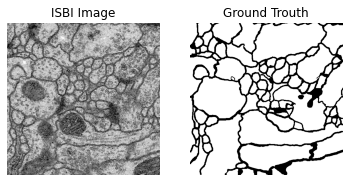

In [5]:
isbi = ISBIDataset()

idx = 5
isbi.show_imgs(idx)

#Train

In [6]:
from torch import optim
import torch.nn as nn
import torch
from tqdm import tqdm

def train(net, device, path='/content/gdrive/MyDrive/train/images/', loss_func=nn.BCEWithLogitsLoss(), epochs=100, batch_size=1, lr=0.00001):

    isbi = ISBIDataset(path)
    data_loader = torch.utils.data.DataLoader(dataset=isbi,batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = loss_func

    best_loss = float('inf')

    net.train()
    for epoch in tqdm(range(epochs)):
        for image, label in data_loader:
            optimizer.zero_grad()

            image = image.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.float32)

            pred = net(image)

            loss = criterion(pred, label)
            print('Loss/train', loss.item())

            if loss < best_loss:
                best_loss = loss
                torch.save(net.state_dict(), '/content/gdrive/MyDrive/ISBI_model.pth')

            loss.backward()
            optimizer.step()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNetPlusPlus()
net.load_state_dict(torch.load('/content/gdrive/MyDrive/ISBI_model.pth'))
net.to(device)
train(net, device)

NameError: ignored

#Inference

In [ ]:
import numpy as np
import torch
import os
import cv2
import glob

THRESOLD = 0.5

PATH = '/content/gdrive/MyDrive/test/res/'
SAVE_PATH = PATH

files = os.listdir(PATH)
imgs = [PATH + file for file in files if os.path.isfile(os.path.join(PATH,file))]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNetPlusPlus()
net.to(device=device)
net.load_state_dict(torch.load('/content/gdrive/MyDrive/ISBI_model.pth', map_location=device))

net.eval()
for idx, img_path in tqdm(enumerate(imgs)):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img[None,None,...]

    img_tensor = torch.from_numpy(img)

    img_tensor = img_tensor.to(device=device, dtype=torch.float32)

    pred = net(img_tensor)

    pred = np.array(pred.data.cpu()[0])[0]

    pred[pred >= THRESOLD] = 255
    pred[pred < THRESOLD] = 0

    cv2.imwrite(SAVE_PATH + f"{files[idx]}", pred)